In [0]:
import numpy as np
import sklearn
import pandas as pd
import string
import nltk
import re

In [0]:
# /from google.colab import drive
# drive.mount('/content/drive')

In [0]:
data = open('train.txt',"r", encoding="utf8")
test_data = open('test.txt',"r", encoding="utf8")

data=list(data)
test=list(test_data)

def extract(data):
    tweets=[]
    sentiments=[]
    arr=[]
    c=0
    handle = 0
    for i in data:
        if(handle == 1):
            handle = 0
            continue
        if(i=="\n"):
            tweets.append(arr)
            arr=[]
        else:
            temp=i.split("\t")
            if(len(temp)==3):
                sentiments.append(temp[2])
            else:
                if temp[0] == '@':
                    handle = 1
                else:
                    arr.append(temp[0].lower())
    tweet=[]
    for i in tweets:
        temp=""
        for j in i:
            temp+=j
            temp+=" "
        tweet.append(temp[:-1])

    tweets=tweet 
    sent=[]
    for i in sentiments:
        temp=i[:-1]
        if(temp=="neutral"):
            sent.append(0)
        elif(temp=="positive"):
            sent.append(1)
        else:
            sent.append(2)  

    return (tweets,sent)


tweets,sent=extract(data)
test_tweets,test_sent = extract(test)

### **Preprocessing**

In [0]:
df = pd.DataFrame()
df['tweet'] = tweets
df['sentiments'] = sent

test_df = pd.DataFrame()
test_df['tweet'] = test_tweets
test_df['sentiments'] = test_sent

In [182]:
#Removing hashtags

def remove_hash(df):
    for i in range(len(df['tweet'])):
        i_arr = df['tweet'][i].split(" ")

        if '#' in i_arr:
            for i in range(len(i_arr)):
                if i_arr[i] == '#':
                    i_arr[i] = '*'
                    i_arr[i+1] = '*'
            df['tweet'][i] = " ".join(i_arr)
    return df

df = remove_hash(df)
test_df = remove_hash(test_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [0]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["tweet"] = df["tweet"].apply(lambda text: remove_punctuation(text))
test_df["tweet"] = test_df["tweet"].apply(lambda text: remove_punctuation(text))


In [0]:
import emoji
from emoji import UNICODE_EMOJI

In [185]:
#replace emojis
def is_emoji(s):
    count = 0
    for emoji in UNICODE_EMOJI:
        count += s.count(emoji)
        if count > 1:
            return False
    return bool(count)

def replace_emoji(text):
    tweet = emoji.demojize(text)
    tweet = tweet.replace(":"," ")
    tweet = ' '.join(tweet.split())
    return tweet

for i in range(len(df['tweet'])):
    df['tweet'][i] = replace_emoji(df['tweet'][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [186]:
for i in range(len(test_df['tweet'])):
    test_df['tweet'][i] = replace_emoji(test_df['tweet'][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
from nltk.corpus import stopwords
# ", ".join(stopwords.words('english'))

In [0]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["tweet"] = df["tweet"].apply(lambda text: remove_stopwords(text))
test_df["tweet"] = test_df["tweet"].apply(lambda text: remove_stopwords(text))

In [189]:
df.head()

,tweet,sentiments
0,pakistan ka ghra tauq pakistan israel ko tasle...,2
1,madarchod mulle ye mathura nahi dikha tha jab ...,2
2,manya pradhan mantri mahoday shriman narendra ...,1
3,krishna jcb full trend chal rahi aa,1
4,loksabha janta sirf modi ko vote de rahi thi n...,1


In [190]:
test_df.head()

,tweet,sentiments
0,rt love looks good maddie ako lang ba yung sob...,0
1,ye ye ye gonna start another june sour note uh...,0
2,lyching mein kahna nae chahta qki mere yaha bt...,0
3,caring bohot jyada caring courier wale bsdk ke...,2
4,54 nonesense kabhi baymani per bani team kamiy...,1


In [191]:
#removing links
def removeLinks(df):
    for i in range(len(df['tweet'])):
        i_arr = df['tweet'][i].split(" ")
        if 'https' in i_arr:
            ind = i_arr.index('https')
            df['tweet'][i] = " ".join(i_arr[:ind])
    return df

df = removeLinks(df)
test_df = removeLinks(test_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
#@title **Machine Learning Models**

In [0]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [0]:
svm_df = df.copy()
svm_df_test = test_df.copy()

In [0]:
svm_df['tweet']= [word_tokenize(entry) for entry in svm_df['tweet']]
svm_df_test['tweet']= [word_tokenize(entry) for entry in svm_df_test['tweet']]

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV


for index,entry in enumerate(svm_df['tweet']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    svm_df.loc[index,'text_final'] = str(Final_words)

for index,entry in enumerate(svm_df_test['tweet']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    svm_df_test.loc[index,'text_final'] = str(Final_words)

In [196]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [0]:
Train_X, Train_Y = svm_df['text_final'],svm_df['sentiments']
Test_X, Test_Y = svm_df_test['text_final'],svm_df_test['sentiments']

In [0]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [0]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(svm_df['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

SVM

In [200]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=4, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)

predictions_SVM = SVM.predict(Test_X_Tfidf)

print("SVM Accuracy Score -> ",accuracy_score(Test_Y, predictions_SVM)*100)
print(classification_report(Test_Y,predictions_SVM))

SVM Accuracy Score ->  55.48421615837347
              precision    recall  f1-score   support

           0       0.52      0.55      0.53       754
           1       0.57      0.55      0.56       582
           2       0.59      0.56      0.57       533

    accuracy                           0.55      1869
   macro avg       0.56      0.56      0.56      1869
weighted avg       0.56      0.55      0.56      1869



Logistic Regression

In [201]:
from sklearn.linear_model import LogisticRegression as LR
model = LR()
model.fit(Train_X_Tfidf,Train_Y)
predictions = model.predict(Test_X_Tfidf)
print(accuracy_score(Test_Y,predictions))
print(classification_report(Test_Y,predictions))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.5516318887105404
              precision    recall  f1-score   support

           0       0.52      0.51      0.52       754
           1       0.57      0.59      0.58       582
           2       0.56      0.56      0.56       533

    accuracy                           0.55      1869
   macro avg       0.55      0.56      0.55      1869
weighted avg       0.55      0.55      0.55      1869



### **Neural Approach**

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Input, Embedding, Activation, Flatten, Dense, LSTM
from keras.layers import Conv1D, MaxPooling1D, Dropout
from keras.models import Model

In [0]:
max_len = 500

In [0]:
train_texts = df['tweet'].values
train_texts = [s.lower()[:max_len] for s in train_texts]

test_texts = test_df['tweet'].values
test_texts = [s.lower()[:max_len] for s in test_texts]

In [0]:
# Tokenizer
tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tk.fit_on_texts(train_texts)
alphabet = "abcdefghijklmnopqrstuvwxyz0123456789"
char_dict = {}
for i, char in enumerate(alphabet):
    char_dict[char] = i + 1

tk.word_index = char_dict.copy()
tk.word_index[tk.oov_token] = max(char_dict.values()) + 1
train_sequences = tk.texts_to_sequences(train_texts)
test_texts = tk.texts_to_sequences(test_texts)

In [0]:
train_data = pad_sequences(train_sequences, maxlen=max_len, padding='post')
test_data = pad_sequences(test_texts, maxlen=max_len, padding='post')

train_data = np.array(train_data, dtype='float32')
test_data = np.array(test_data, dtype='float32')

train_class_list = df['sentiments'].values

test_class_list = test_df['sentiments'].values

from keras.utils import to_categorical

train_classes = to_categorical(train_class_list)
test_classes = to_categorical(test_class_list)

In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### **Char - Level CNN**

### Model 1

In [215]:
input_size = max_len
vocab_size = len(tk.word_index)
embedding_size = 37

fully_connected_layers = [1024, 1024]
num_of_classes = 3
dropout_p = 0.5
optimizer = 'adam'
loss = 'categorical_crossentropy'

embedding_weights = []  
embedding_weights.append(np.zeros(vocab_size)) 

for char, i in tk.word_index.items(): 
    onehot = np.zeros(vocab_size)
    onehot[i - 1] = 1
    embedding_weights.append(onehot)

embedding_weights = np.array(embedding_weights)
embedding_layer = Embedding(vocab_size + 1, embedding_size, input_length=input_size, weights=[embedding_weights])


inputs = Input(shape=(input_size,), name='input', dtype='int64')
x = embedding_layer(inputs)

for filter_num, filter_size, pooling_size in [[256, 7, 3], [256, 7, 3], [256, 3, -1], [256, 3, -1],[256, 3, -1], [256, 3, 3]]:
    x = Conv1D(filter_num, filter_size)(x)
    x = Activation('relu')(x)
    if pooling_size != -1:
        x = MaxPooling1D(pool_size=pooling_size)(x)

x = LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)(x)

for dense_size in fully_connected_layers:
    x = Dense(dense_size, activation='relu')(x)
    x = Dropout(dropout_p)(x)

predictions = Dense(num_of_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

model.summary()

indices = np.arange(train_data.shape[0])
np.random.shuffle(indices)

x_train = train_data[indices]
y_train = train_classes[indices]

x_test = test_data
y_test = test_classes

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 500)               0         
_________________________________________________________________
embedding_28 (Embedding)     (None, 500, 37)           1406      
_________________________________________________________________
conv1d_156 (Conv1D)          (None, 494, 256)          66560     
_________________________________________________________________
activation_156 (Activation)  (None, 494, 256)          0         
_________________________________________________________________
max_pooling1d_80 (MaxPooling (None, 164, 256)          0         
_________________________________________________________________
conv1d_157 (Conv1D)          (None, 158, 256)          459008    
_________________________________________________________________
activation_157 (Activation)  (None, 158, 256)          0  

In [216]:
model.fit(x_train, y_train,batch_size=128,epochs=10, verbose=1, validation_split=0.2)

Train on 12104 samples, validate on 3027 samples
Epoch 1/10
12104/12104 [==============================] - 15s 1ms/step - loss: 1.0947 - acc: 0.3736 - f1_m: 0.0061 - precision_m: 0.0690 - recall_m: 0.0037 - val_loss: 1.0949 - val_acc: 0.3693 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/10
12104/12104 [==============================] - 6s 482us/step - loss: 1.0950 - acc: 0.3733 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0941 - val_acc: 0.3693 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/10
12104/12104 [==============================] - 6s 485us/step - loss: 1.0920 - acc: 0.3758 - f1_m: 0.0032 - precision_m: 0.0382 - recall_m: 0.0017 - val_loss: 1.0454 - val_acc: 0.4351 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/10
12104/12104 [==============================] - 6s 488us/step - loss: 1.0211 - acc: 0.4512 - f1_m: 0.1827 - 

In [217]:
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=1)

1869/1869 [==============================] - 1s 448us/step


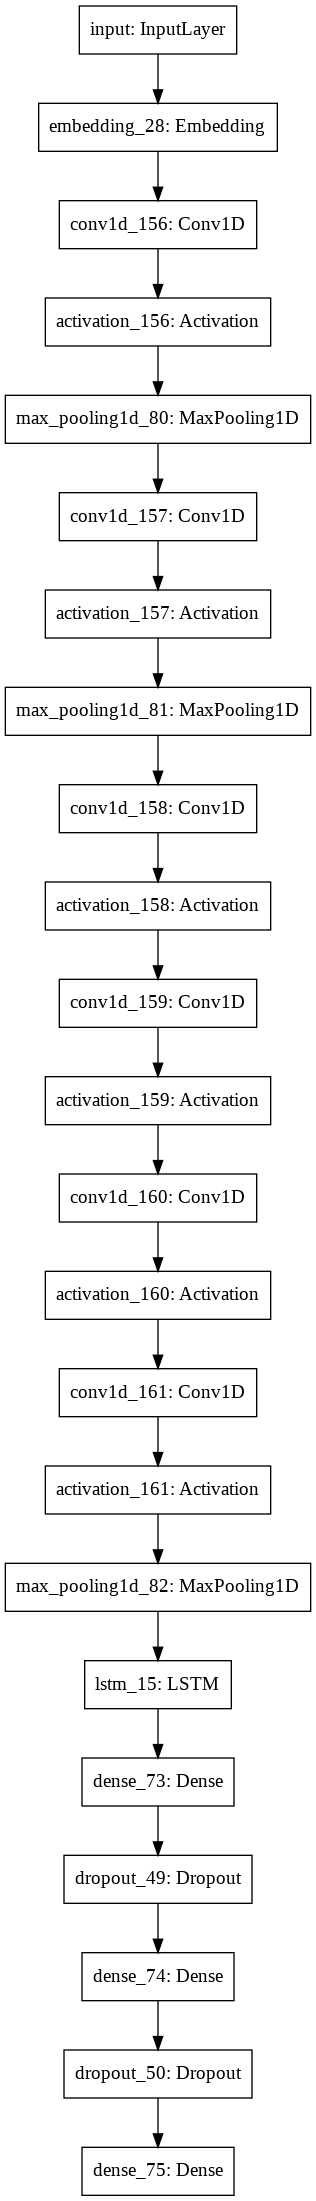

In [221]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [218]:
print("Accuracy:", accuracy)
print("\nF1-Score:", f1_score)
print("\nPrecision:", precision)
print("\nRecall:", recall)

Accuracy: 0.5238095239689798

F1-Score: 0.5170907742075259

Precision: 0.5264892727694708

Recall: 0.5082932050818744


In [0]:
predictions = model.predict(x_test)
y_pred = [np.argmax(j) for j in predictions]
y_test_mod = [np.argmax(j) for j in y_test]

In [220]:
print(classification_report(y_test_mod, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.52      0.51       754
           1       0.57      0.55      0.56       582
           2       0.52      0.51      0.51       533

    accuracy                           0.52      1869
   macro avg       0.53      0.52      0.53      1869
weighted avg       0.52      0.52      0.52      1869

